In [2]:
import torch
import torchvision.datasets as datasets
import matplotlib.pyplot as plt
import os
import os.path
from pathlib import Path
import cv2
import numpy as np
import random
import math
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
from torchvision.datasets import MNIST
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader,random_split
import torch.nn as nn
import numpy as np
import torch.nn.functional as F

OSError: [WinError 1455] The paging file is too small for this operation to complete. Error loading "C:\Users\asvp0\Anaconda3\envs\dl21\lib\site-packages\torch\lib\shm.dll" or one of its dependencies.

In [121]:
def transform_img2pc(img):
    img_array = np.asarray(img)
    indices = np.argwhere(img_array > 100)
    return indices.astype(np.float32)

In [122]:
dataset = MNIST(root='./data', train=True, download=True)
len_points = []
for idx in range(len(dataset)):
    img,label = dataset[idx]
    pc = transform_img2pc(img)
    len_points.append(len(pc))

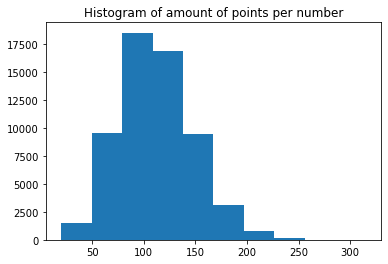

In [123]:
h = plt.hist(len_points)
plt.title('Histogram of amount of points per number')
plt.savefig('figures/histogram_points_minst.png',dpi=100)

In [124]:
min(len_points)

20

In [125]:
##Normalize - axis limits change
class Normalize(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2
        
        #np.mean(pointcloud, axis=1)
        #np.expand_dims(np.mean(pointcloud, axis=1), axis=-1)
        norm_pointcloud = pointcloud - np.expand_dims(np.mean(pointcloud, axis=1), axis=-1)
        norm_pointcloud /= np.max(np.linalg.norm(norm_pointcloud, axis=1))

        return  norm_pointcloud

In [126]:
class PointSampler(object):
    torch.manual_seed(100)
    def __init__(self, output_size):
        assert isinstance(output_size, int)
        self.output_size = output_size
    
    def __call__(self, pointcloud):
        sampled_points = np.zeros((self.output_size, 2))
        for i in range(self.output_size):
            sampled_points[i] = pointcloud[random.randint(0, pointcloud.T.shape[1] - 1)]
            i += 1                   
        return sampled_points
    
# np.random.randint(0, pointcloud.shape[0]-1)  

In [127]:
## adding random noise to the point cloud
class RandomNoise(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        noise = np.random.normal(0, 0.002, (pointcloud.shape))
    
        noisy_pointcloud = pointcloud + noise
        return  noisy_pointcloud

In [128]:
## adding random rotation to the point cloud
class RandRotation_z(object):
    def __call__(self, pointcloud):
        assert len(pointcloud.shape)==2

        theta = random.random() * 2. * math.pi
        rot_matrix = np.array([[ math.cos(theta), -math.sin(theta)],
                               [ math.sin(theta),  math.cos(theta)]])
        
        rot_pointcloud = rot_matrix.dot(pointcloud.T).T
        return  rot_pointcloud

In [129]:
class ToTensor(object):
    def __call__(self, pointcloud):
        #assert len(pointcloud.shape)==2

        return torch.from_numpy(pointcloud)
# ToTensor()(noisy_rot_pointcloud)  

In [130]:
def default_transforms():
    return transforms.Compose([
                                Normalize(),
                                ToTensor()
                              ])   

In [131]:
class MNIST2D(Dataset):
    """2D MNIST dataset."""
    
    NUM_CLASSIFICATION_CLASSES = 10
    POINT_DIMENSION = 2

    def __init__(self, dataset, num_points=500, transform=default_transforms()):
        self.dataset = dataset
        self.transforms = transform
        self.number_of_points = num_points

    def __len__(self):
        return len(self.dataset)
    
    def __preproc__(self, pointcloud):
        if self.transforms:
            pointcloud = self.transforms(pointcloud.T)
        return pointcloud
    
    def __getitem__(self, idx):

        img,label = dataset[idx]
        pc = transform_img2pc(img)   
        if self.number_of_points-pc.shape[0]>0:
            # repeat some points to reach uniform number of points
            sampling_indices = np.random.choice(pc.shape[0], self.number_of_points-pc.shape[0])
            new_points = pc[sampling_indices, :]
            pc = np.concatenate((pc, new_points),axis=0)
        else:
            sampling_indices = np.random.choice(pc.shape[0], self.number_of_points)
            pc = pc[sampling_indices, :]
        pc = self.__preproc__(pc)            
        
        return pc, label

In [132]:
## Hyperparameters

dataset='MNIST2D'
number_of_points=200
batch_size=128
learning_rate=0.001
number_of_workers=0
train_transforms = transforms.Compose([
                    Normalize(),
                    RandRotation_z(),
                    RandomNoise(),
                    ToTensor()
                    ])

In [133]:
## Dataloaders

train_dataset = MNIST(root='./data/MNIST', download=True, train=True)
test_dataset = MNIST(root='./data/MNIST', download=True, train=False)
dataset = torch.utils.data.ConcatDataset([train_dataset, test_dataset])

dataset_2d = MNIST2D(dataset, number_of_points)
l_data = len(dataset_2d)
train_dataset, val_dataset, test_dataset = random_split(dataset_2d,
                                          [round(0.8*l_data), round(0.1*l_data), round(0.1*l_data)],
                                          generator=torch.Generator().manual_seed(1))

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, drop_last=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [134]:
train_dataset

In [135]:
class Tnet(nn.Module):
    def __init__(self, k=2):
        super().__init__()
        self.k=k
        self.conv1 = nn.Conv1d(k,64,1)
        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
        self.fc1 = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512,256)
        self.fc3 = nn.Linear(256,k*k)

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
        self.bn4 = nn.BatchNorm1d(512)
        self.bn5 = nn.BatchNorm1d(256)
       

    def forward(self, input):
        # input.shape == (bs,n,2)
        bs = input.size(0)
        xb = F.relu(self.bn1(self.conv1(input)))
        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = F.relu(self.bn3(self.conv3(xb)))
        pool = nn.MaxPool1d(xb.size(-1))(xb)
        flat = nn.Flatten(1)(pool)
        xb = F.relu(self.bn4(self.fc1(flat)))
        xb = F.relu(self.bn5(self.fc2(xb)))

        #initialize as identity
        init = torch.eye(self.k, requires_grad=True).repeat(bs,1,1)
        if xb.is_cuda:
            init=init.cuda()
        matrix = self.fc3(xb).view(-1,self.k,self.k) + init
        return matrix


class Transform(nn.Module):
    def __init__(self):
        super().__init__()
        self.input_transform = Tnet(k=2)
        self.feature_transform = Tnet(k=64)
        self.conv1 = nn.Conv1d(2,64,1)

        self.conv2 = nn.Conv1d(64,128,1)
        self.conv3 = nn.Conv1d(128,1024,1)
       

        self.bn1 = nn.BatchNorm1d(64)
        self.bn2 = nn.BatchNorm1d(128)
        self.bn3 = nn.BatchNorm1d(1024)
       
    def forward(self, input):
        matrix2x2 = self.input_transform(input)
        # batch matrix multiplication
        xb = torch.bmm(torch.transpose(input,1,2), matrix2x2).transpose(1,2)

        xb = F.relu(self.bn1(self.conv1(xb)))

        matrix64x64 = self.feature_transform(xb)
        xb = torch.bmm(torch.transpose(xb,1,2), matrix64x64).transpose(1,2)

        xb = F.relu(self.bn2(self.conv2(xb)))
        xb = self.bn3(self.conv3(xb))
        xb = nn.MaxPool1d(xb.size(-1))(xb)
        output = nn.Flatten(1)(xb)
        return output, matrix2x2, matrix64x64

class PointNet(nn.Module):
    def __init__(self, classes = 10):
        super().__init__()
        self.transform = Transform()
        self.fc1 = nn.Linear(1024, 512)
        self.fc2 = nn.Linear(512, 256)
        self.fc3 = nn.Linear(256, classes)
        

        self.bn1 = nn.BatchNorm1d(512)
        self.bn2 = nn.BatchNorm1d(256)
        self.dropout = nn.Dropout(p=0.3)
        self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, input):
        xb, matrix2x2, matrix64x64 = self.transform(input)
        xb = F.relu(self.bn1(self.fc1(xb)))
        xb = F.relu(self.bn2(self.dropout(self.fc2(xb))))
        output = self.fc3(xb)
        return self.logsoftmax(output), matrix2x2, matrix64x64

In [136]:
def pointnetloss(outputs, labels, m2x2, m64x64, alpha = 0.0001):
    criterion = torch.nn.NLLLoss()
    bs=outputs.size(0)
    id2x2 = torch.eye(2, requires_grad=True).repeat(bs,1,1)
    id64x64 = torch.eye(64, requires_grad=True).repeat(bs,1,1)
    if outputs.is_cuda:
        id2x2=id2x2.cuda()
        id64x64=id64x64.cuda()
    diff2x2 = id2x2-torch.bmm(m2x2,m2x2.transpose(1,2))
    diff64x64 = id64x64-torch.bmm(m64x64,m64x64.transpose(1,2))
    return criterion(outputs, labels) + alpha * (torch.norm(diff2x2)+torch.norm(diff64x64)) / float(bs)

In [137]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [138]:
pointnet = PointNet()
pointnet.to(device);

In [139]:
optimizer = torch.optim.Adam(pointnet.parameters(), lr=0.001)

In [140]:
def train(model, train_loader, val_loader=None,  epochs= 5, save=True):
    for epoch in range(epochs): 
        pointnet.train()
        running_loss = 0.0
        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            if torch.cuda.is_available():
                inputs, labels = inputs.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs, m3x3, m64x64 = pointnet(inputs)

            loss = pointnetloss(outputs, labels, m3x3, m64x64)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()
            if i % 10 == 9:    # print every 10 mini-batches
                    print('[Epoch: %d, Batch: %4d / %4d], loss: %.3f' %
                        (epoch + 1, i + 1, len(train_loader), running_loss / 10))
                    running_loss = 0.0

        pointnet.eval()
        correct = total = 0

        # validation
        if val_loader:
            with torch.no_grad():
                for data in val_dataloader:
                    inputs, labels = data
                    if torch.cuda.is_available():
                        inputs, labels = inputs.cuda(), labels.cuda()
                    outputs, __, __ = pointnet(inputs)
                    _, predicted = torch.max(outputs.data, 1)
                    total += labels.size(0)
                    correct += (predicted == labels).sum().item()
            val_acc = 100. * correct / total
            print('Valid accuracy: %d %%' % val_acc)

        # save the model
        if save:
            torch.save(pointnet.state_dict(), "save_"+str(epoch)+".pth")

In [141]:
train(pointnet, train_dataloader, val_dataloader,  save=True)

[Epoch: 1, Batch:   10 /  437], loss: 1.917
[Epoch: 1, Batch:   20 /  437], loss: 1.306
[Epoch: 1, Batch:   30 /  437], loss: 0.980
[Epoch: 1, Batch:   40 /  437], loss: 0.727
[Epoch: 1, Batch:   50 /  437], loss: 0.564
[Epoch: 1, Batch:   60 /  437], loss: 0.572
[Epoch: 1, Batch:   70 /  437], loss: 0.490
[Epoch: 1, Batch:   80 /  437], loss: 0.449
[Epoch: 1, Batch:   90 /  437], loss: 0.393
[Epoch: 1, Batch:  100 /  437], loss: 0.342
[Epoch: 1, Batch:  110 /  437], loss: 0.296
[Epoch: 1, Batch:  120 /  437], loss: 0.364
[Epoch: 1, Batch:  130 /  437], loss: 0.266
[Epoch: 1, Batch:  140 /  437], loss: 0.302
[Epoch: 1, Batch:  150 /  437], loss: 0.236
[Epoch: 1, Batch:  160 /  437], loss: 0.276
[Epoch: 1, Batch:  170 /  437], loss: 0.289
[Epoch: 1, Batch:  180 /  437], loss: 0.301
[Epoch: 1, Batch:  190 /  437], loss: 0.258
[Epoch: 1, Batch:  200 /  437], loss: 0.249
[Epoch: 1, Batch:  210 /  437], loss: 0.217
[Epoch: 1, Batch:  220 /  437], loss: 0.232
[Epoch: 1, Batch:  230 /  437], 

[Epoch: 5, Batch:  140 /  437], loss: 0.099
[Epoch: 5, Batch:  150 /  437], loss: 0.072
[Epoch: 5, Batch:  160 /  437], loss: 0.074
[Epoch: 5, Batch:  170 /  437], loss: 0.084
[Epoch: 5, Batch:  180 /  437], loss: 0.122
[Epoch: 5, Batch:  190 /  437], loss: 0.095
[Epoch: 5, Batch:  200 /  437], loss: 0.074
[Epoch: 5, Batch:  210 /  437], loss: 0.051
[Epoch: 5, Batch:  220 /  437], loss: 0.084
[Epoch: 5, Batch:  230 /  437], loss: 0.085
[Epoch: 5, Batch:  240 /  437], loss: 0.077
[Epoch: 5, Batch:  250 /  437], loss: 0.071
[Epoch: 5, Batch:  260 /  437], loss: 0.056
[Epoch: 5, Batch:  270 /  437], loss: 0.060
[Epoch: 5, Batch:  280 /  437], loss: 0.076
[Epoch: 5, Batch:  290 /  437], loss: 0.097
[Epoch: 5, Batch:  300 /  437], loss: 0.087
[Epoch: 5, Batch:  310 /  437], loss: 0.129
[Epoch: 5, Batch:  320 /  437], loss: 0.105
[Epoch: 5, Batch:  330 /  437], loss: 0.093
[Epoch: 5, Batch:  340 /  437], loss: 0.093
[Epoch: 5, Batch:  350 /  437], loss: 0.056
[Epoch: 5, Batch:  360 /  437], 

In [142]:
# test evaluation
correct = total = 0
with torch.no_grad():
    for data in test_dataloader:
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()
        outputs, __, __ = pointnet(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
test_acc = 100. * correct / total
print('test accuracy: %d %%' % test_acc)

test accuracy: 91 %


In [143]:
from sklearn.metrics import confusion_matrix

In [144]:
all_preds = []
all_labels = []
with torch.no_grad():
    for i, data in enumerate(test_dataloader):
        print('Batch [%4d / %4d]' % (i+1, len(test_dataloader)))
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()    
        outputs, __, __ = pointnet(inputs)
        _, preds = torch.max(outputs.data, 1)
        all_preds += list(preds.cpu().numpy())
        all_labels += list(labels.cpu().numpy())

Batch [   1 /   55]
Batch [   2 /   55]
Batch [   3 /   55]
Batch [   4 /   55]
Batch [   5 /   55]
Batch [   6 /   55]
Batch [   7 /   55]
Batch [   8 /   55]
Batch [   9 /   55]
Batch [  10 /   55]
Batch [  11 /   55]
Batch [  12 /   55]
Batch [  13 /   55]
Batch [  14 /   55]
Batch [  15 /   55]
Batch [  16 /   55]
Batch [  17 /   55]
Batch [  18 /   55]
Batch [  19 /   55]
Batch [  20 /   55]
Batch [  21 /   55]
Batch [  22 /   55]
Batch [  23 /   55]
Batch [  24 /   55]
Batch [  25 /   55]
Batch [  26 /   55]
Batch [  27 /   55]
Batch [  28 /   55]
Batch [  29 /   55]
Batch [  30 /   55]
Batch [  31 /   55]
Batch [  32 /   55]
Batch [  33 /   55]
Batch [  34 /   55]
Batch [  35 /   55]
Batch [  36 /   55]
Batch [  37 /   55]
Batch [  38 /   55]
Batch [  39 /   55]
Batch [  40 /   55]
Batch [  41 /   55]
Batch [  42 /   55]
Batch [  43 /   55]
Batch [  44 /   55]
Batch [  45 /   55]
Batch [  46 /   55]
Batch [  47 /   55]
Batch [  48 /   55]
Batch [  49 /   55]
Batch [  50 /   55]


In [145]:
cm = confusion_matrix(all_labels, all_preds);
cm

array([[220,   0,   0,   0,   0,   0,  55,   0,   0,   0],
       [  0, 495,   0,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0, 495,   0,   0,   0,   0,   0,   0,   0],
       [  0,   0,  55, 385,   0,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0, 440,   0,   0,   0,   0,   0],
       [  0,   0,   0,   0,   0, 385,  55,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0, 825,   0,   0,   0],
       [  0,   0,   0,   0,   0,   0,   0, 385,   0,   0],
       [  0,   0,   0,   0,   0,   0,  55,   0, 495,   0],
       [  0,   0,   0,   0, 385,   0,   0,   0,   0, 110]], dtype=int64)

In [146]:
classes = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]

In [147]:
import itertools
import matplotlib.pyplot as plt

# function from https://deeplizard.com/learn/video/0LhiS6yu2qQ
def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


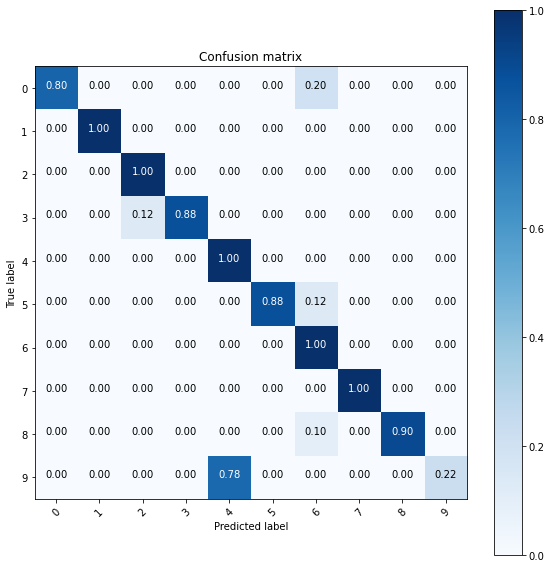

In [148]:
plt.figure(figsize=(8,8))
plot_confusion_matrix(cm, list(classes), normalize=True)